In [1]:
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
import torchvision
from torchvision import datasets,transforms 
from torch.utils.data import Dataset, DataLoader,TensorDataset,random_split,SubsetRandomSampler
from torchvision import datasets,transforms

DEVICE = torch.device("cpu")
transform = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])
train_dataset = torchvision.datasets.ImageFolder('./input/train',transform=transform)
test_dataset  = torchvision.datasets.ImageFolder('./input/valid',transform=transform)

# Get the number of features
input_shape=len(train_dataset)
train_data, val_data = random_split(train_dataset, [input_shape-int(input_shape*0.2), int(input_shape*0.2)])

y_train = np.array([y for x, y in iter(train_dataset)])
y_test = np.array([y for x, y in iter(test_dataset)])

In [27]:
import torch.nn as nn
from torch.nn import functional as F

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=16, kernel_size=5, stride=1, padding=2)

        self.conv2 = nn.Conv2d(in_channels=16, out_channels=32, kernel_size=5, stride=1, padding=2)
        
        self.first_layer = nn.Linear(32768, 64)
        
        self.second_layer = nn.Linear(64, 10)

    def forward(self, x):
        
        x = F.relu(F.max_pool2d(self.conv1(x),kernel_size = 2))
        
        x = F.relu(F.max_pool2d(self.conv2(x),kernel_size = 2))
        
        x = x.view(x.size(0),-1)
        x = F.relu(self.first_layer(x))
        
        x = self.second_layer(x)
        return x


In [28]:
from skorch import NeuralNetClassifier

torch.manual_seed(0)

net = NeuralNetClassifier(
    ConvNet,
    max_epochs=10,
    iterator_train__num_workers=4,
    iterator_valid__num_workers=4,
    lr=1e-3,
    batch_size=64,
    optimizer=optim.Adam,
    criterion=nn.CrossEntropyLoss,
    device=DEVICE
)

In [29]:
net.fit(train_dataset, y=y_train);

  epoch    train_loss    valid_acc    valid_loss      dur
-------  ------------  -----------  ------------  -------
      1       13.9595       0.4209        1.4563  58.0152
      2        1.2597       0.4209        1.3504  45.0797
      3        1.1481       0.4209        0.7881  36.1753
      4        0.8474       0.4209        0.7585  35.7079
      5        0.8228       0.4209        0.7401  34.7153
      6        0.8068       0.4209        0.7274  34.8924
      7        0.7885       0.4268        0.7200  36.0094
      8        0.7768       0.4502        0.7140  35.5824
      9        0.7520       0.4209        0.7615  36.5749
     10        0.7917       0.4521        0.7101  45.3730


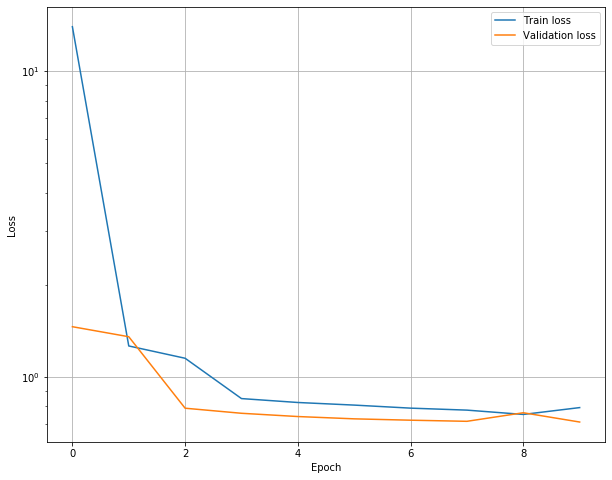

In [30]:
import matplotlib.pyplot as plt

val_loss=[]
train_loss=[]
for i in range(10):
    val_loss.append(net.history[i]['valid_loss'])
    train_loss.append(net.history[i]['train_loss'])
    
plt.figure(figsize=(10,8))
plt.semilogy(train_loss, label='Train loss')
plt.semilogy(val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid()
plt.legend()
plt.show() 